In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     RepeatedKFold,
                                     cross_val_score)
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier)
from xgboost import XGBClassifier
from sklearn.metrics import (precision_score,
                             f1_score,
                             roc_auc_score,
                             make_scorer)
from sklearn.impute import SimpleImputer

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/"

df = pd.read_csv(f"{path}filtered_customer_booking.csv", index_col=0)

In [4]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


## Feature Encoding

Mapping "flight day" with corresponding day number of a week.

In [5]:
mapping = {
    "Mon" : 1,
    "Tue" : 2,
    "Wed" : 3,
    "Thu" : 4,
    "Fri" : 5,
    "Sat" : 6,
    "Sun" : 7
}

df.flight_day = df.flight_day.map(mapping)

In [6]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [7]:
df.booking_origin.isnull().sum()

0

In [8]:
df = df.dropna(axis=0)
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [9]:
# create instance of one hot encoder
encoder = OneHotEncoder(handle_unknown='ignore')

# one hot encode Sales Channel
encoder_df = pd.DataFrame(encoder.fit_transform(df[["sales_channel"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'internet', 1:'mobile'})
df = df.join(encoder_df)

# one hot encode trip type
encoder_df = pd.DataFrame(encoder.fit_transform(df[["trip_type"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'round_trip', 1:'oneway_trip',2:'circle_trip'})
df = df.join(encoder_df)


In [10]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,internet,mobile,round_trip,oneway_trip,circle_trip
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,1.0,0.0,0.0,0.0,1.0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,1.0,0.0,0.0,0.0,1.0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,1.0,0.0,0.0,0.0,1.0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,1.0,0.0,0.0,0.0,1.0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,1.0,0.0,0.0,0.0,1.0


### Drop categorical columns now

In [11]:
categorical_columns = ['sales_channel', 'trip_type','booking_origin', 'route']

In [12]:
df.drop(categorical_columns, axis=1, inplace = True)

In [13]:
df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,internet,mobile,round_trip,oneway_trip,circle_trip
0,2,262,19,7,6,1,0,0,5.52,0,1.0,0.0,0.0,0.0,1.0
1,1,112,20,3,6,0,0,0,5.52,0,1.0,0.0,0.0,0.0,1.0
2,2,243,22,17,3,1,1,0,5.52,0,1.0,0.0,0.0,0.0,1.0
3,1,96,31,4,6,0,0,1,5.52,0,1.0,0.0,0.0,0.0,1.0
4,2,68,22,15,3,1,0,1,5.52,0,1.0,0.0,0.0,0.0,1.0


### Correlation of features

In [14]:
cols = df.columns
for col in cols:
    f = df['booking_complete'].corr(df[col])
    print(f"{col} has {f:.3f} correlation with the Target(booking_complete)")

num_passengers has 0.024 correlation with the Target(booking_complete)
purchase_lead has -0.022 correlation with the Target(booking_complete)
length_of_stay has -0.057 correlation with the Target(booking_complete)
flight_hour has 0.007 correlation with the Target(booking_complete)
flight_day has -0.007 correlation with the Target(booking_complete)
wants_extra_baggage has 0.068 correlation with the Target(booking_complete)
wants_preferred_seat has 0.051 correlation with the Target(booking_complete)
wants_in_flight_meals has 0.026 correlation with the Target(booking_complete)
flight_duration has -0.107 correlation with the Target(booking_complete)
booking_complete has 1.000 correlation with the Target(booking_complete)
internet has -0.004 correlation with the Target(booking_complete)
mobile has 0.004 correlation with the Target(booking_complete)
round_trip has -0.005 correlation with the Target(booking_complete)
oneway_trip has -0.005 correlation with the Target(booking_complete)
circle_

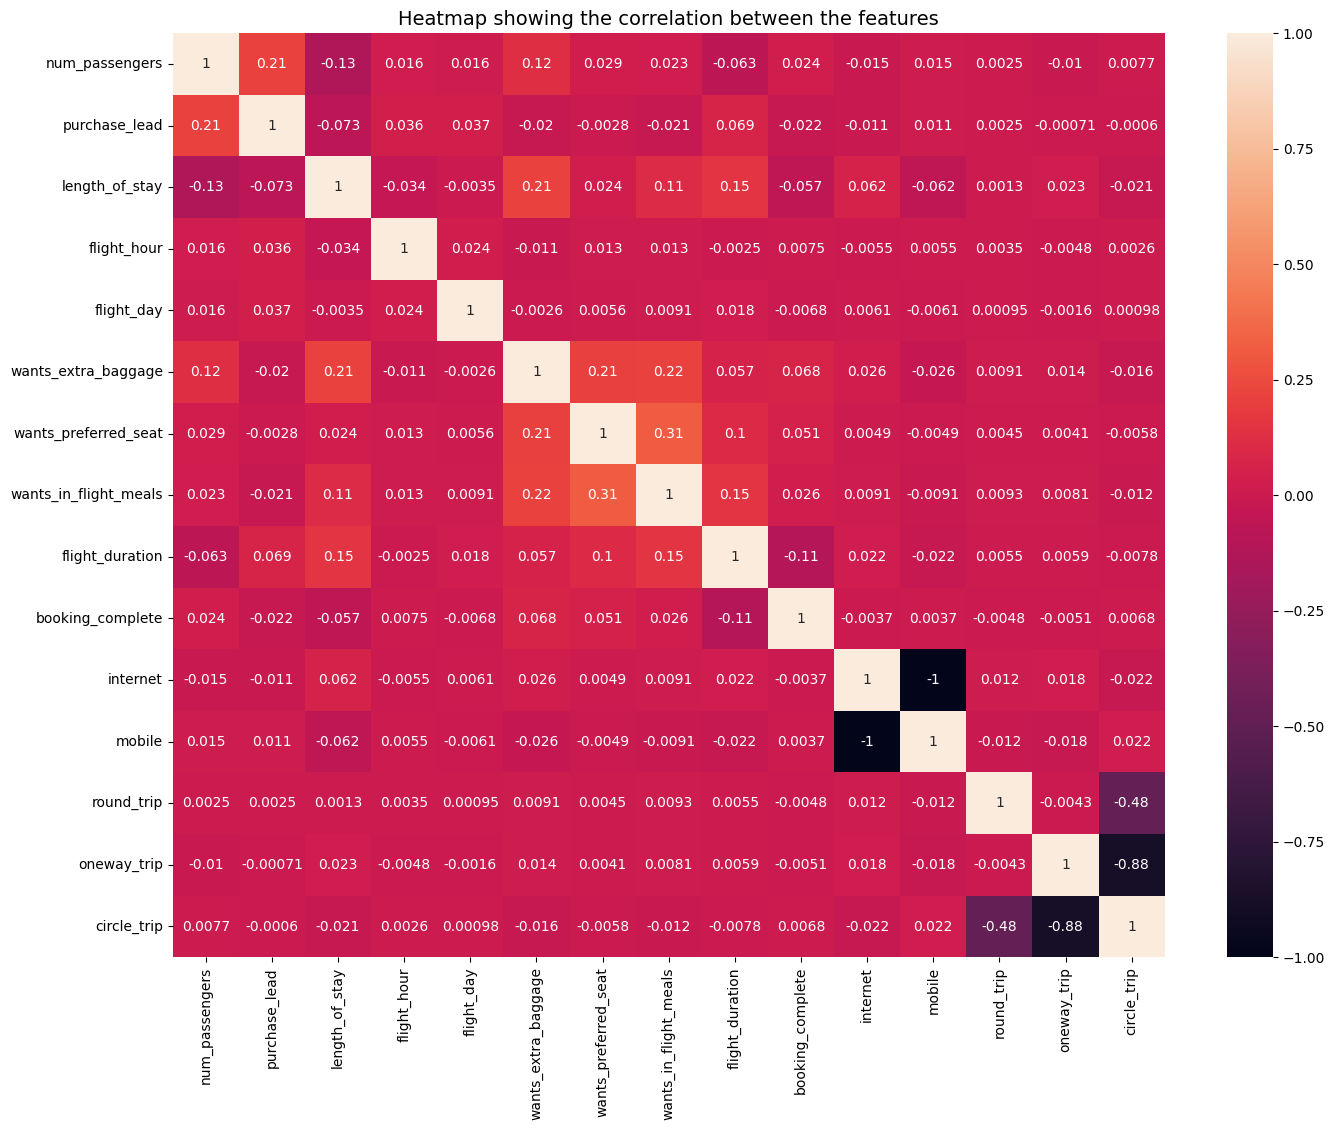

In [15]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr(), annot=True)
plt.title("Heatmap showing the correlation between the features", fontsize=14)
plt.show()

## Handling Missing Values

In [16]:
imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='mean')

In [17]:
cols1 = ['num_passengers', 'purchase_lead', "length_of_stay", "flight_hour", "flight_day",
        "wants_extra_baggage", "wants_preferred_seat", "wants_in_flight_meals",
        "flight_duration", "internet", "mobile", "round_trip", "oneway_trip", "circle_trip"]

In [18]:
imputer.fit(df[cols1])

SimpleImputer()

In [19]:
df[cols1] = imputer.fit_transform(df[cols1])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49699 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49699 non-null  float64
 1   purchase_lead          49699 non-null  float64
 2   length_of_stay         49699 non-null  float64
 3   flight_hour            49699 non-null  float64
 4   flight_day             49699 non-null  float64
 5   wants_extra_baggage    49699 non-null  float64
 6   wants_preferred_seat   49699 non-null  float64
 7   wants_in_flight_meals  49699 non-null  float64
 8   flight_duration        49699 non-null  float64
 9   booking_complete       49699 non-null  int64  
 10  internet               49699 non-null  float64
 11  mobile                 49699 non-null  float64
 12  round_trip             49699 non-null  float64
 13  oneway_trip            49699 non-null  float64
 14  circle_trip            49699 non-null  float64
dtypes: floa

## Features and Target Separation

In [21]:
X = df.drop(columns=['booking_complete'], axis=1)
y = df.loc[:, 'booking_complete']

In [22]:
X.shape

(49699, 14)

In [23]:
y.shape

(49699,)

## Split Data

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape

(44729, 14)

In [25]:
y_train.shape

(44729,)

## Feature Scaling (Normalization)

In [26]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train = pd.DataFrame(X_scaled, columns = X.columns)
X_val = pd.DataFrame(X_val_scaled, columns = X.columns)

In [27]:
y_train.value_counts()

booking_complete
0    38039
1     6690
Name: count, dtype: int64

We can see that there is a high class imbalance in the target variable.<br>There are more incomplete bookings (0) to complete bookings (1).
To solve this and improve the accuracy of the model, we employ SMOTEENN.

In [28]:
# SmoteENN
smote_enn = SMOTEENN(random_state=42)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

## Model Training

### Cross-Validation

#### Training Accuracy

In [29]:
# Cross-Validation

models_scores = ['XGB', 'ExtraTrees', 'RF']
models = [XGBClassifier(n_estimators=1000, class_weight='balanced'),
          ExtraTreesClassifier(n_estimators=1000, class_weight='balanced'),
          RandomForestClassifier(n_estimators=1000, class_weight='balanced')]
index = 0
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

for model in models_scores:
    score = cross_val_score(models[index], X_train, y_train,
                            scoring= 'roc_auc', cv=cv, n_jobs=-1)
    print(f"{model} Classifier Model Mean area under the ROC curve : {score.mean():.2f}.")
    index += 1

XGB Classifier Model Mean area under the ROC curve : 0.97.
ExtraTrees Classifier Model Mean area under the ROC curve : 1.00.
RF Classifier Model Mean area under the ROC curve : 0.99.


## Training and Evaluation

In [30]:
# Training

xgb = XGBClassifier(n_estimators=1000, class_weight='balanced').fit(X_train, y_train)
et = ExtraTreesClassifier(n_estimators=1000, class_weight='balanced').fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=1000, class_weight='balanced').fit(X_train, y_train)

#### Testing Accuracy

In [34]:
n = 0
predictions = [xgb.predict(X_val),
               et.predict(X_val),
               rf.predict(X_val)]

for model in models_scores:
    precision = precision_score(y_val, predictions[n])
    f1 = f1_score(y_val, predictions[n])
    roc = roc_auc_score(y_val, predictions[n])
    print(f"\nTesting Accuracy - {model}:\nPrecision = {precision:.2f}\nF1 Score = {f1:.2f}\nROC AUC = {roc:.2f}")

    n += 1


Testing Accuracy - XGB:
Precision = 0.26
F1 Score = 0.28
ROC AUC = 0.58

Testing Accuracy - ExtraTrees:
Precision = 0.25
F1 Score = 0.32
ROC AUC = 0.60

Testing Accuracy - RF:
Precision = 0.28
F1 Score = 0.33
ROC AUC = 0.61


#### Random Forest Classifier is the Best performing model

## Hyperparameter Optimization

In [35]:
roc_auc_scorer = make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True)
parameters = {
              'n_estimators':[100,500,1000],
              'max_depth':[4,6,8,10,],
              'max_leaf_nodes': [3, 6, 9],
              }

opt_model = RandomizedSearchCV(estimator=rf, param_distributions=parameters,
                          scoring=roc_auc_scorer, n_jobs=-1, cv=cv)

In [36]:
# Optimization

mod = opt_model.fit(X_train, y_train)

In [37]:
print(f"Best Hyperparameters: {mod.best_params_}")
best_est = mod.best_estimator_
print(f"Best score: {np.absolute(mod.best_score_)}")

Best Hyperparameters: {'n_estimators': 1000, 'max_leaf_nodes': 9, 'max_depth': 8}
Best score: 0.7988021713526766


In [38]:
model = best_est

### Evaluation after HyperParameter Optimization

In [39]:
score = cross_val_score(model, X_train, y_train,
                        scoring='roc_auc', cv=cv, n_jobs=-1)

print(f"Training Accuracy After optimization:\nArea under the ROC curve  = {score.mean():.2f}\n")

Training Accuracy After optimization:
Area under the ROC curve  = 0.80



In [40]:
model.fit(X_train, y_train)

opt_pred = model.predict(X_val)

In [41]:
precision = precision_score(y_val, opt_pred)
f1 = f1_score(y_val, opt_pred)
roc = roc_auc_score(y_val, opt_pred)
print(f"\nTesting Accuracy After optimization:\nPrecision = {precision:.2f}\nF1 Score = {f1:.2f}\nROC AUC = {roc:.2f}")


Testing Accuracy After optimization:
Precision = 0.23
F1 Score = 0.33
ROC AUC = 0.62


## Feature Importance

Text(0.5, 1.0, 'Random Forest Model Feature Importance (After Hyperparameter Optimization)')

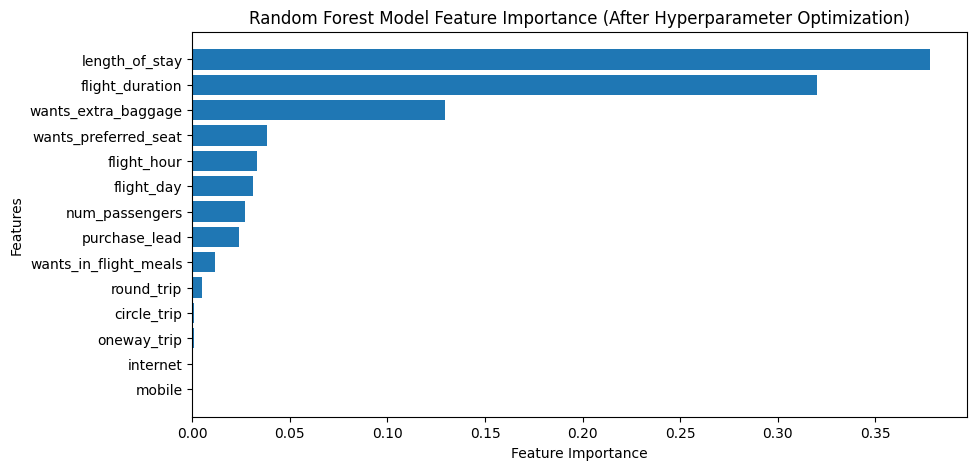

In [42]:
plt.figure(figsize=(10,5))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Model Feature Importance (After Hyperparameter Optimization)")
